In [1]:
%matplotlib inline

In [2]:
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 16

# Hide deprecation warnings from Theano
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
import numpy as np
from astroquery.mast import Catalogs

ticid = 261136679

tic = Catalogs.query_object("TIC {0}".format(ticid), radius=0.01, catalog="TIC")
star = tic[np.argmin(tic["dstArcSec"])]

In [4]:
from io import BytesIO
from zipfile import ZipFile

from astropy.io import fits
from astropy.utils.data import download_file

# Download the cutout
url = "https://mast.stsci.edu/tesscut/api/v0.1/astrocut?ra={0[ra]}&dec={0[dec]}&y=15&x=15&units=px&sector=All".format(star)
fn = download_file(url, cache=True)
with ZipFile(fn, "r") as f:
    with fits.open(BytesIO(f.read(f.namelist()[0]))) as hdus:
        tpf = hdus[1].data
        tpf_hdr = hdus[1].header

texp = tpf_hdr["FRAMETIM"] * tpf_hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0
time = tpf["TIME"]
flux = tpf["FLUX"]
m = np.any(np.isfinite(flux), axis=(1, 2)) & (tpf["QUALITY"] == 0)
ref_time = 0.5 * (np.min(time[m])+np.max(time[m]))
time = np.ascontiguousarray(time[m] - ref_time, dtype=np.float64)
flux = np.ascontiguousarray(flux[m], dtype=np.float64)

# Compute the median image
mean_img = np.median(flux, axis=0)

# Sort the pixels by median brightness
order = np.argsort(mean_img.flatten())[::-1]

# Choose a mask for the background
bkg_mask = np.zeros_like(mean_img, dtype=bool)
bkg_mask[np.unravel_index(order[-100:], mean_img.shape)] = True
flux -= np.median(flux[:, bkg_mask], axis=-1)[:, None, None]

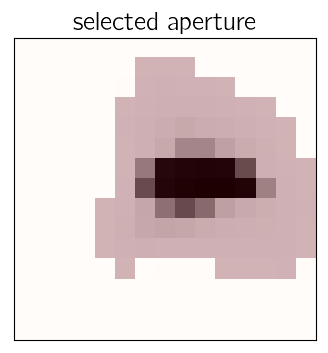

In [5]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# A function to estimate the windowed scatter in a lightcurve
def estimate_scatter_with_mask(mask):
    f = np.sum(flux[:, mask], axis=-1)
    smooth = savgol_filter(f, 1001, polyorder=5)
    return 1e6 * np.sqrt(np.median((f / smooth - 1)**2))

# Loop over pixels ordered by brightness and add them one-by-one
# to the aperture
masks, scatters = [], []
for i in range(1, 100):
    msk = np.zeros_like(mean_img, dtype=bool)
    msk[np.unravel_index(order[:i], mean_img.shape)] = True
    scatter = estimate_scatter_with_mask(msk)
    masks.append(msk)
    scatters.append(scatter)

# Choose the aperture that minimizes the scatter
pix_mask = masks[np.argmin(scatters)]

# Plot the selected aperture
plt.imshow(mean_img.T, cmap="gray_r")
plt.imshow(pix_mask.T, cmap="Reds", alpha=0.3)
plt.title("selected aperture")
plt.xticks([])
plt.yticks([]);

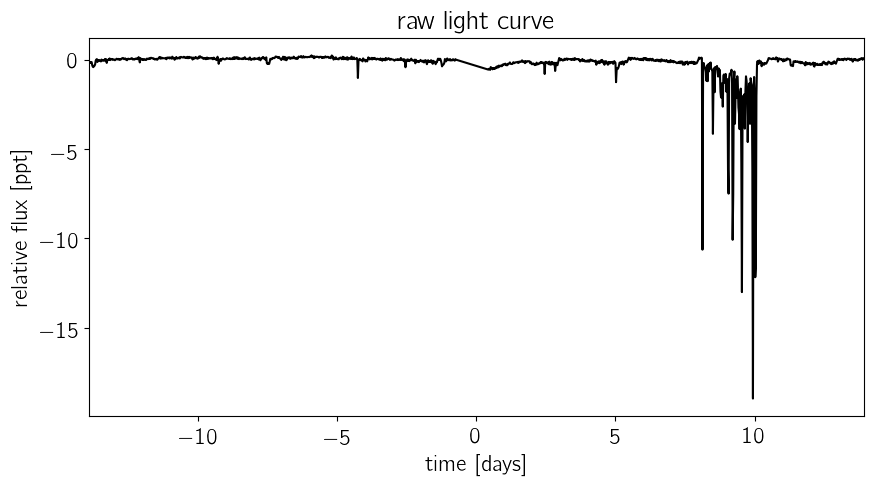

In [6]:
plt.figure(figsize=(10, 5))
sap_flux = np.sum(flux[:, pix_mask], axis=-1)
sap_flux = (sap_flux / np.median(sap_flux) - 1) * 1e3
plt.plot(time, sap_flux, "k")
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.title("raw light curve")
plt.xlim(time.min(), time.max());

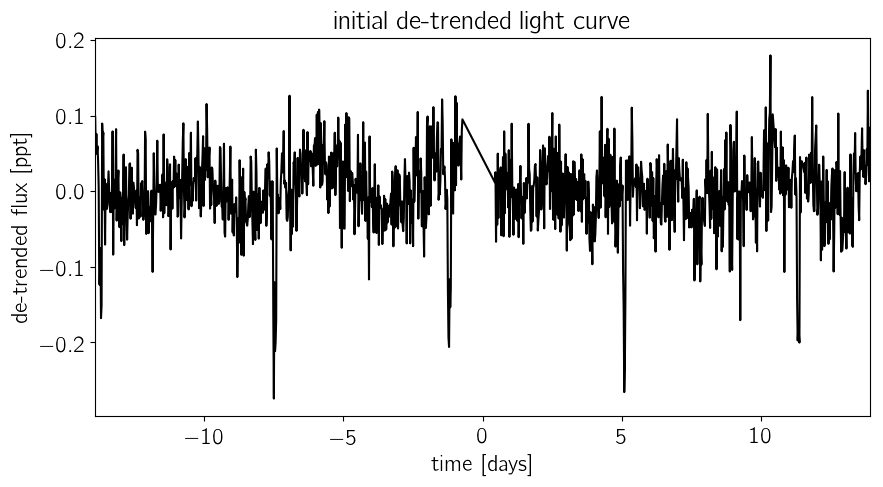

In [7]:
# Build the first order PLD basis
X_pld = np.reshape(flux[:, pix_mask], (len(flux), -1))
X_pld = X_pld / np.sum(flux[:, pix_mask], axis=-1)[:, None]

# Build the second order PLD basis and run PCA to reduce the number of dimensions
X2_pld = np.reshape(X_pld[:, None, :] * X_pld[:, :, None], (len(flux), -1))
U, _, _ = np.linalg.svd(X2_pld, full_matrices=False)
X2_pld = U[:, :X_pld.shape[1]]

# Construct the design matrix and fit for the PLD model
X_pld = np.concatenate((np.ones((len(flux), 1)), X_pld, X2_pld), axis=-1)
XTX = np.dot(X_pld.T, X_pld)
w_pld = np.linalg.solve(XTX, np.dot(X_pld.T, sap_flux))
pld_flux = np.dot(X_pld, w_pld)

# Plot the de-trended light curve
plt.figure(figsize=(10, 5))
plt.plot(time, sap_flux-pld_flux, "k")
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("initial de-trended light curve")
plt.xlim(time.min(), time.max());

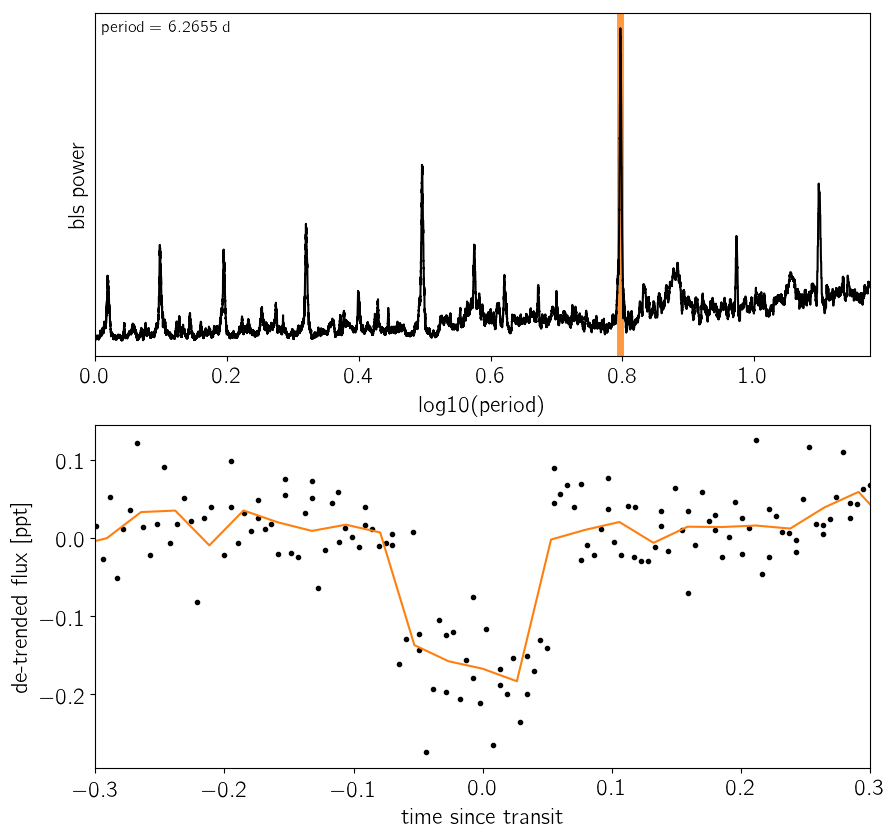

In [8]:
from astropy.stats import BoxLeastSquares

period_grid = np.exp(np.linspace(np.log(1), np.log(15), 50000))

bls = BoxLeastSquares(time, sap_flux - pld_flux)
bls_power = bls.power(period_grid, 0.1, oversample=20)

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
transit_mask = bls.transit_mask(time, bls_period, 0.2, bls_t0)

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Plot the periodogram
ax = axes[0]
ax.axvline(np.log10(bls_period), color="C1", lw=5, alpha=0.8)
ax.plot(np.log10(bls_power.period), bls_power.power, "k")
ax.annotate("period = {0:.4f} d".format(bls_period),
            (0, 1), xycoords="axes fraction",
            xytext=(5, -5), textcoords="offset points",
            va="top", ha="left", fontsize=12)
ax.set_ylabel("bls power")
ax.set_yticks([])
ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
ax.set_xlabel("log10(period)")

# Plot the folded transit
ax = axes[1]
x_fold = (time - bls_t0 + 0.5*bls_period)%bls_period - 0.5*bls_period
m = np.abs(x_fold) < 0.4
ax.plot(x_fold[m], sap_flux[m] - pld_flux[m], ".k")

# Overplot the phase binned light curve
bins = np.linspace(-0.41, 0.41, 32)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=sap_flux - pld_flux)
denom[num == 0] = 1.0
ax.plot(0.5*(bins[1:] + bins[:-1]), num / denom, color="C1")

ax.set_xlim(-0.3, 0.3)
ax.set_ylabel("de-trended flux [ppt]")
ax.set_xlabel("time since transit");

In [9]:
print("""
period: {0}
t0: {1}
""".format(bls_period, bls_t0))


period: 6.2655456440909605
t0: -1.1904126180680787



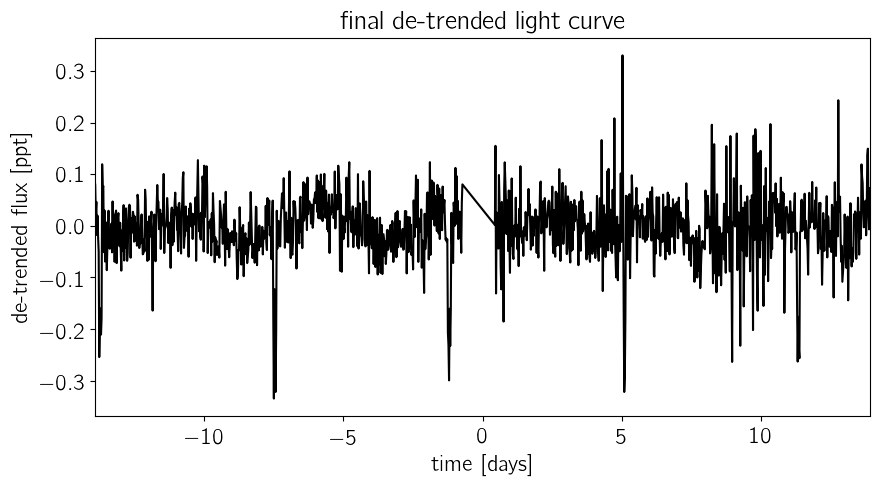

In [9]:
m = ~transit_mask
XTX = np.dot(X_pld[m].T, X_pld[m])
w_pld = np.linalg.solve(XTX, np.dot(X_pld[m].T, sap_flux[m]))
pld_flux = np.dot(X_pld, w_pld)

x = np.ascontiguousarray(time, dtype=np.float64)
y = np.ascontiguousarray(sap_flux-pld_flux, dtype=np.float64)

plt.figure(figsize=(10, 5))
plt.plot(time, y, "k")
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("final de-trended light curve")
plt.xlim(time.min(), time.max());

In [10]:
import pymc3 as pm
import theano.tensor as tt

import exoplanet as xo

with pm.Model() as model:
    mean = pm.Normal("mean", mu=0, sd=1)
    
    # Transit jitter & GP parameters
    logs2 = pm.Normal("logs2", mu=np.log(np.var(y[~transit_mask])), sd=10)
    logw0_guess = np.log(2*np.pi/10)
    logw0 = pm.Normal("logw0", mu=logw0_guess, sd=10)

    # We'll parameterize using the maximum power (S_0 * w_0^4) instead of
    # S_0 directly because this removes some of the degeneracies between
    # S_0 and omega_0
    logpower = pm.Normal("logpower",
                         mu=np.log(np.var(y[~transit_mask]))+4*logw0_guess,
                         sd=10)
    logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)

    kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
    gp = xo.gp.GP(kernel, x[~transit_mask], tt.exp(logs2) + tt.zeros((~transit_mask).sum()), J=2)
    pm.Potential("transit_obs", gp.log_likelihood(y[~transit_mask] - mean))
    pm.Deterministic("gp_pred", gp.predict(x) + mean)
    
    soln = xo.optimize()

success: False
initial logp: 1847.6053482098976
final logp: 1857.1356673460975


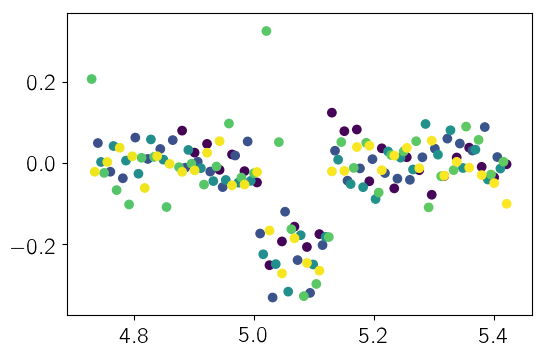

In [11]:
m = transit_mask = bls.transit_mask(time, bls_period, 0.7, bls_t0)
plt.scatter(x[m] % bls_period, y[m]-soln["gp_pred"][m], c=x[m])

In [17]:
x_fit = x[m]
y_fit = y[m]

with pm.Model() as model:
    # Parameters for the stellar properties
    mean = pm.Normal("mean", mu=0.0, sd=10.0)
    u_star = xo.distributions.QuadLimbDark("u_star")

    # Stellar parameters from TIC
    M_star_huang = 1.094, 0.039
    R_star_huang = 1.10, 0.023
    m_star = pm.Normal("m_star", mu=M_star_huang[0], sd=M_star_huang[1])
    r_star = pm.Normal("r_star", mu=R_star_huang[0], sd=R_star_huang[1])

    # Prior to require physical parameters
    pm.Potential("m_star_prior", tt.switch(m_star > 0, 0, -np.inf))
    pm.Potential("r_star_prior", tt.switch(r_star > 0, 0, -np.inf))

    # Orbital parameters for the planets
    logP = pm.Normal("logP", mu=np.log(bls_period), sd=1)
    t0 = pm.Normal("t0", mu=bls_t0, sd=1)
    b = pm.Uniform("b", lower=0, upper=1, testval=0.5)
    logr = pm.Normal("logr", sd=1.0,
                     mu=0.5*np.log(1e-3*np.array(bls_depth))+np.log(R_star_huang[0]))
    r_pl = pm.Deterministic("r_pl", tt.exp(logr))
    ror = pm.Deterministic("ror", r_pl / r_star)

    # Transit jitter & GP parameters
    logs2 = pm.Normal("logs2", mu=np.log(np.var(y_fit)), sd=10)

    # Tracking planet parameters
    period = pm.Deterministic("period", tt.exp(logP))

    # Orbit model
    orbit = xo.orbits.KeplerianOrbit(
        r_star=r_star, m_star=m_star,
        period=period, t0=t0, b=b)
    pm.Deterministic("a", orbit.a_planet)
    pm.Deterministic("incl", orbit.incl)

    # Compute the model light curve using starry
    light_curves = xo.StarryLightCurve(u_star).get_light_curve(
        orbit=orbit, r=r_pl, t=x_fit, texp=texp)*1e3
    light_curve = pm.math.sum(light_curves, axis=-1) + mean
    pm.Deterministic("light_curves", light_curves)

    # Observation model
    logp_good = pm.Normal.dist(mu=light_curve, sd=tt.exp(0.5*logs2)).logp(y_fit)
    
    Q = pm.Uniform("Q", lower=0, upper=1, testval=0.9)
    logV = pm.Normal("logV", mu=np.log(np.var(y_fit)), sd=10)
    logp_bad = pm.Normal.dist(mu=mean, sd=tt.exp(0.5*logV)).logp(y_fit)
    
    pm.Deterministic("log_P_good", logp_good - pm.math.logaddexp(logp_good, logp_bad))
    
    pm.Potential("obs", Q * logp_good + (1 - Q) * logp_bad)

    # Fit for the maximum a posteriori parameters, I've found that I can get
    # a better solution by trying different combinations of parameters in turn
    start = model.test_point
    map_soln = xo.optimize(start=start, vars=[logs2])
    map_soln = xo.optimize(start=map_soln, vars=[logr, b])
    map_soln = xo.optimize(start=map_soln)

success: True
initial logp: 160.0353748917257
final logp: 174.0532440159224
success: False
initial logp: 174.0532440159224
final logp: 179.93593666715108
success: False
initial logp: 179.93593666715108
final logp: 191.96174572353914


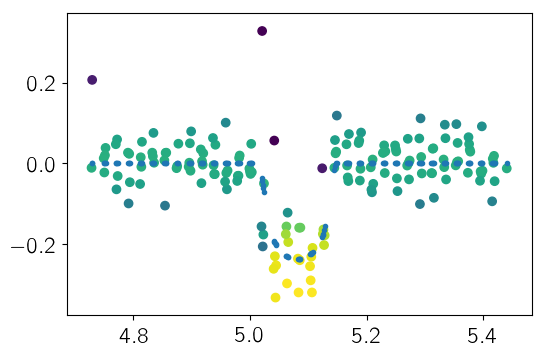

In [22]:
plt.scatter(x_fit%map_soln["period"], y_fit, c=np.exp(map_soln["log_P_good"]))
plt.plot(x_fit%map_soln["period"], map_soln["light_curves"], ".")

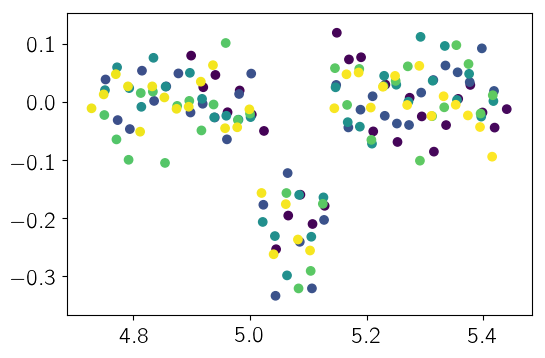

In [26]:
m = np.exp(map_soln["log_P_good"]) > 0.2
plt.scatter(x_fit[m]%map_soln["period"], y_fit[m], c=x_fit[m])

In [27]:
data = np.array(list(zip(x_fit[m], y_fit[m])), dtype=[("time", float), ("flux", float)])

In [29]:
fits.writeto("pimen-ffi.fits", data, header=tpf_hdr, overwrite=True)

In [30]:
!open .